In [2]:
# Create timeline showing availability of weekly vs general bills
def create_coverage_timeline():
    """Create timeline showing availability of weekly vs general bills."""
    
    # Count records by year and bill type
    yearly_counts = bills.groupby(['year', 'bill_type']).size().unstack(fill_value=0)
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), sharex=True)
    fig.suptitle('Bills of Mortality: Data Availability Over Time', fontsize=16, fontweight='bold')
    
    # Plot record counts (log scale for better visibility)
    if 'weekly' in yearly_counts.columns:
        ax1.bar(yearly_counts.index, yearly_counts['weekly'], 
               alpha=0.7, label='Weekly Bills', color='skyblue', width=0.8)
    if 'general' in yearly_counts.columns:
        ax1.bar(yearly_counts.index, yearly_counts['general'], 
               alpha=0.7, label='General Bills', color='orange', 
               bottom=yearly_counts.get('weekly', 0), width=0.8)
    
    ax1.set_ylabel('Number of Records (log scale)')
    ax1.set_title('Record Counts by Year and Bill Type', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # Plot presence/absence
    presence_data = (yearly_counts > 0).astype(int)
    bottom_vals = np.zeros(len(yearly_counts))
    
    if 'weekly' in presence_data.columns:
        ax2.bar(presence_data.index, presence_data['weekly'], 
               alpha=0.7, label='Weekly Bills Available', color='skyblue', width=0.8)
        bottom_vals = presence_data['weekly']
    
    if 'general' in presence_data.columns:
        ax2.bar(presence_data.index, presence_data['general'], 
               alpha=0.7, label='General Bills Available', color='orange', 
               bottom=bottom_vals, width=0.8)
    
    # Highlight major gap period
    ax2.axvspan(1680, 1699, alpha=0.3, color='red', label='General Bills Gap')
    
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Data Type Available')
    ax2.set_title('Data Availability by Bill Type', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_yticks([0, 1, 2])
    ax2.set_yticklabels(['None', 'One Type', 'Both Types'])
    
    # Add annotation for major gap
    ax2.annotate('General Bills\\nMissing 1680-1699', 
                xy=(1690, 0.5), xytext=(1710, 1.5),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                fontsize=10, ha='center', color='red')
    
    plt.tight_layout()
    plt.show()

# Generate the visualization
print("📊 Creating data coverage timeline...")
create_coverage_timeline()

print("\\n✅ Coverage analysis complete!")
print(f"\\nSummary of findings:")
print(f"- General Bills missing for 1680-1699 ({len([y for y in bill_gaps.get('general', []) if 1680 <= y <= 1699])} years)")  
print(f"- Weekly Bills missing for scattered early years ({len(bill_gaps.get('weekly', []))} years total)")
print(f"- Overall parish coverage rate: {coverage_df['coverage_rate'].mean():.1%}")

# Export coverage data for further analysis if needed
coverage_summary = {
    'general_gaps': bill_gaps.get('general', []),
    'weekly_gaps': bill_gaps.get('weekly', []), 
    'parish_coverage_rate': coverage_df['coverage_rate'].mean(),
    'parishes_with_gaps': len(coverage_df[coverage_df['years_missing'] > 0])
}

print(f"\\n📋 Coverage summary stored in 'coverage_summary' variable for further analysis.")

📊 Creating data coverage timeline...


NameError: name 'bills' is not defined

## Coverage Visualization

In [3]:
# Data coverage analysis functions
def analyze_coverage_gaps():
    """Analyze missing years for each bill type."""
    gaps = {}
    
    for bill_type in bills['bill_type'].unique():
        type_data = bills[bills['bill_type'] == bill_type]
        years_with_data = set(type_data['year'].unique())
        
        if years_with_data:
            year_min, year_max = min(years_with_data), max(years_with_data)
            years_expected = set(range(year_min, year_max + 1))
            missing_years = sorted(list(years_expected - years_with_data))
            gaps[bill_type] = missing_years
    
    return gaps

def analyze_parish_coverage():
    """Analyze data coverage by parish across years."""
    
    coverage_data = []
    
    # Get parish name mapping if available
    parish_names = {}
    if parishes is not None:
        parish_names = dict(zip(parishes['id'], parishes['parish_name']))
    
    for parish_id in bills['parish_id'].unique():
        parish_data = bills[bills['parish_id'] == parish_id]
        parish_name = parish_names.get(parish_id, f'Parish {parish_id}')
        
        years_with_data = sorted(parish_data['year'].unique())
        if not years_with_data:
            continue
            
        year_min, year_max = min(years_with_data), max(years_with_data)
        years_expected = set(range(year_min, year_max + 1))
        years_missing = years_expected - set(years_with_data)
        
        # Count by bill type
        weekly_years = set(parish_data[parish_data['bill_type'] == 'weekly']['year'].unique())
        general_years = set(parish_data[parish_data['bill_type'] == 'general']['year'].unique())
        
        coverage_data.append({
            'parish_id': parish_id,
            'parish_name': parish_name,
            'year_min': year_min,
            'year_max': year_max,
            'years_span': year_max - year_min + 1,
            'years_with_data': len(years_with_data),
            'years_missing': len(years_missing),
            'coverage_rate': len(years_with_data) / len(years_expected) if years_expected else 0,
            'missing_years': sorted(list(years_missing)),
            'weekly_years': len(weekly_years),
            'general_years': len(general_years),
            'total_records': len(parish_data)
        })
    
    return pd.DataFrame(coverage_data)

print("📅 Data Coverage Analysis by Parish and Year")
print("=" * 50)

# Basic coverage statistics  
print(f"📊 Basic Coverage Statistics:")
print(f"Total records: {len(bills):,}")
print(f"Years covered: {bills['year'].min()} - {bills['year'].max()}")
print(f"Number of years with data: {bills['year'].nunique()}")
print(f"Number of parishes: {bills['parish_id'].nunique()}")

# Bill type breakdown
bill_type_counts = bills['bill_type'].value_counts()
print(f"\nBill Types:")
for bill_type, count in bill_type_counts.items():
    print(f"  {bill_type.title()}: {count:,} records")

# Identify bill type gaps
bill_gaps = analyze_coverage_gaps()

print(f"\n📅 Bill Type Gaps Analysis:")
for bill_type, missing_years in bill_gaps.items():
    if missing_years:
        print(f"\n{bill_type.title()} Bills missing for years:")
        # Group consecutive years for cleaner output
        groups = []
        if missing_years:
            current_group = [missing_years[0]]
            
            for year in missing_years[1:]:
                if year == current_group[-1] + 1:
                    current_group.append(year)
                else:
                    groups.append(current_group)
                    current_group = [year]
            groups.append(current_group)
            
            for group in groups:
                if len(group) == 1:
                    print(f"  {group[0]}")
                else:
                    print(f"  {group[0]}-{group[-1]} ({len(group)} years)")

# Analyze parish coverage
coverage_df = analyze_parish_coverage()

print(f"\n🏛️ Parish Coverage Summary:")
print(f"  Average coverage rate: {coverage_df['coverage_rate'].mean():.2%}")
print(f"  Parishes with 100% coverage: {(coverage_df['coverage_rate'] == 1.0).sum()}")
print(f"  Parishes with <90% coverage: {(coverage_df['coverage_rate'] < 0.9).sum()}")

# Show parishes with most missing years
worst_coverage = coverage_df.nlargest(10, 'years_missing')
if len(worst_coverage) > 0 and worst_coverage.iloc[0]['years_missing'] > 0:
    print(f"\nParishes with most missing years:")
    for _, parish in worst_coverage.iterrows():
        if parish['years_missing'] > 0:
            print(f"  {parish['parish_name'][:35]:35} - {parish['years_missing']:2d} missing ({parish['year_min']}-{parish['year_max']})")

print(f"\n🔍 Key Coverage Gaps Identified:")

# Highlight specific issues mentioned by user  
general_gaps = bill_gaps.get('general', [])
weekly_gaps = bill_gaps.get('weekly', [])

if general_gaps:
    # Focus on the years mentioned: 1666, '67, '68, and 1700, '01
    mentioned_general = [y for y in general_gaps if y in [1666, 1667, 1668, 1700, 1701]]
    other_general = [y for y in general_gaps if y not in mentioned_general]
    
    if mentioned_general:
        print(f"  🔴 General Bills missing for years you mentioned: {mentioned_general}")
    if other_general:
        if len(other_general) <= 10:
            print(f"  🟡 Other missing General Bill years: {other_general}")
        else:
            print(f"  🟡 Other missing General Bill years: {other_general[:5]}...{other_general[-5:]} ({len(other_general)} total)")

if weekly_gaps:
    early_weekly = [y for y in weekly_gaps if y < 1660]
    late_weekly = [y for y in weekly_gaps if y >= 1660]
    
    if early_weekly:
        print(f"  🔴 Early Weekly Bills missing: {early_weekly}")
    if late_weekly:
        print(f"  🟡 Late Weekly Bills missing: {late_weekly}")

# Store results for potential further analysis
coverage_analysis_results = {
    'coverage_df': coverage_df,
    'bill_gaps': bill_gaps,
    'bill_type_counts': bill_type_counts
}

📅 Data Coverage Analysis by Parish and Year
📊 Basic Coverage Statistics:


NameError: name 'bills' is not defined

# Bills of Mortality - Data Quality Assessment

This notebook provides a comprehensive assessment of data quality in the Bills of Mortality dataset, including:
- Missing data patterns
- Data consistency checks
- Outlier detection
- Historical plausibility assessment
- Recommendations for data cleaning

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats
from datetime import datetime
import re

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)
warnings.filterwarnings('ignore')

# Data directory
DATA_DIR = Path('../data')

print("🔍 Bills of Mortality - Data Quality Assessment")
print("="*50)

🔍 Bills of Mortality - Data Quality Assessment


## Load and Examine Raw Data Structure

In [5]:
# Load all datasets
datasets = {}
file_paths = {
    'bills': 'all_bills.csv',
    'parishes': 'parishes.csv',
    'years': 'years.csv',
    'weeks': 'weeks.csv'
}

for name, filename in file_paths.items():
    filepath = DATA_DIR / filename
    if filepath.exists():
        datasets[name] = pd.read_csv(filepath)
        print(f"✓ Loaded {name}: {len(datasets[name]):,} records")
    else:
        print(f"✗ Missing file: {filepath}")

# Check if we have the main dataset
if 'bills' not in datasets:
    print("❌ Cannot proceed without main bills dataset")
    exit()

bills = datasets['bills']
parishes = datasets.get('parishes')
years = datasets.get('years')
weeks = datasets.get('weeks')

print(f"\n📊 Primary Dataset Info:")
print(f"Shape: {bills.shape}")
print(f"Columns: {list(bills.columns)}")
print(f"Memory usage: {bills.memory_usage(deep=True).sum() / (1024*1024):.2f} MB")

# Data types
print(f"\n📋 Data Types:")
for col, dtype in bills.dtypes.items():
    unique_count = bills[col].nunique()
    null_count = bills[col].isnull().sum()
    print(f"  {col:20} {str(dtype):10} - {unique_count:>6,} unique, {null_count:>6,} nulls")

✓ Loaded bills: 1,305,300 records
✓ Loaded parishes: 153 records
✓ Loaded years: 113 records
✓ Loaded weeks: 5,393 records

📊 Primary Dataset Info:
Shape: (1305300, 10)
Columns: ['parish_id', 'count_type', 'count', 'year', 'joinid', 'bill_type', 'missing', 'illegible', 'source', 'unique_identifier']
Memory usage: 345.15 MB

📋 Data Types:
  parish_id            int64      -    153 unique,      0 nulls
  count_type           object     -      2 unique,      0 nulls
  count                int64      -  1,220 unique,      0 nulls
  year                 int64      -    115 unique,      0 nulls
  joinid               int64      -  5,236 unique,      0 nulls
  bill_type            object     -      2 unique,      0 nulls
  missing              bool       -      2 unique,      0 nulls
  illegible            bool       -      1 unique,      0 nulls
  source               object     -     12 unique,      0 nulls
  unique_identifier    object     -  5,374 unique,      0 nulls


## Missing Data Analysis

In [6]:
# Comprehensive missing data assessment
missing_summary = []

for col in bills.columns:
    null_count = bills[col].isnull().sum()
    null_pct = (null_count / len(bills)) * 100
    missing_summary.append({
        'column': col,
        'null_count': null_count,
        'null_percentage': null_pct,
        'data_type': str(bills[col].dtype)
    })

missing_df = pd.DataFrame(missing_summary).sort_values('null_percentage', ascending=False)

print(f"🕳️ Missing Data Summary:")
print("="*45)
for _, row in missing_df.iterrows():
    if row['null_count'] > 0:
        print(f"  {row['column']:20} - {row['null_count']:>6,} missing ({row['null_percentage']:>5.1f}%)")

if missing_df['null_count'].sum() == 0:
    print("  ✅ No missing values detected in any column")

# Visualize missing data patterns
if missing_df['null_count'].sum() > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Missing data heatmap
    missing_data = bills.isnull()
    sns.heatmap(missing_data.T, cbar=True, ax=axes[0], cmap='viridis')
    axes[0].set_title('Missing Data Pattern (Dark = Missing)')
    axes[0].set_xlabel('Records (sample)')
    
    # Missing data bar chart
    missing_cols = missing_df[missing_df['null_count'] > 0]
    if not missing_cols.empty:
        axes[1].barh(missing_cols['column'], missing_cols['null_percentage'], color='red', alpha=0.7)
        axes[1].set_xlabel('Percentage Missing')
        axes[1].set_title('Missing Data by Column')
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Check for patterns in missing data
print(f"\n🔍 Missing Data Patterns:")
if 'year' in bills.columns:
    missing_by_year = bills.groupby('year').apply(lambda x: x.isnull().sum().sum()).sort_values(ascending=False)
    if missing_by_year.sum() > 0:
        print(f"Years with most missing data:")
        for year, missing_count in missing_by_year.head(5).items():
            if missing_count > 0:
                print(f"  {year}: {missing_count} missing values")
    else:
        print(f"  No missing data patterns by year")

if 'parish_id' in bills.columns and missing_df['null_count'].sum() > 0:
    missing_by_parish = bills.groupby('parish_id').apply(lambda x: x.isnull().sum().sum()).sort_values(ascending=False)
    if missing_by_parish.sum() > 0:
        print(f"\nParishes with most missing data:")
        for parish_id, missing_count in missing_by_parish.head(5).items():
            if missing_count > 0:
                parish_name = parishes.set_index('id')['parish_name'].get(parish_id, f'Parish {parish_id}') if parishes is not None else f'Parish {parish_id}'
                print(f"  {parish_name[:30]:30} - {missing_count} missing values")

🕳️ Missing Data Summary:
  ✅ No missing values detected in any column

🔍 Missing Data Patterns:
  No missing data patterns by year


## Data Consistency Checks

In [7]:
consistency_issues = []

print(f"🔄 Data Consistency Checks:")
print("="*35)

# 1. Check for negative death counts
if 'count' in bills.columns:
    negative_counts = bills[bills['count'] < 0]
    if len(negative_counts) > 0:
        print(f"❌ Negative death counts: {len(negative_counts)} records")
        consistency_issues.append(f"Negative death counts: {len(negative_counts)} records")
    else:
        print(f"✅ No negative death counts")

# 2. Check for unreasonably high death counts
if 'count' in bills.columns:
    q99 = bills['count'].quantile(0.99)
    extreme_counts = bills[bills['count'] > q99 * 3]  # 3x the 99th percentile
    if len(extreme_counts) > 0:
        max_count = bills['count'].max()
        print(f"⚠️ Extremely high death counts: {len(extreme_counts)} records (max: {max_count})")
        consistency_issues.append(f"Extremely high death counts: {len(extreme_counts)} records")
        
        # Show the highest counts
        top_counts = bills.nlargest(5, 'count')[['parish_id', 'year', 'week_id', 'count', 'count_type']]
        print(f"  Top 5 highest counts:")
        for _, record in top_counts.iterrows():
            parish_name = parishes.set_index('id')['parish_name'].get(record['parish_id'], f'Parish {record["parish_id"]}') if parishes is not None else f'Parish {record["parish_id"]}'
            print(f"    {parish_name[:25]:25} {record['year']} - {record['count']} deaths")
    else:
        print(f"✅ No extremely high death counts")

# 3. Check year ranges
if 'year' in bills.columns:
    min_year, max_year = bills['year'].min(), bills['year'].max()
    print(f"📅 Year range: {min_year} - {max_year}")
    
    # Check for implausible years
    implausible_years = bills[(bills['year'] < 1500) | (bills['year'] > 1800)]
    if len(implausible_years) > 0:
        print(f"❌ Implausible years: {len(implausible_years)} records")
        consistency_issues.append(f"Implausible years: {len(implausible_years)} records")
    else:
        print(f"✅ All years within plausible range")

# 4. Check parish ID consistency
if parishes is not None and 'parish_id' in bills.columns:
    bill_parishes = set(bills['parish_id'].unique())
    parish_table_ids = set(parishes['id'].unique())
    
    missing_parish_refs = bill_parishes - parish_table_ids
    unused_parishes = parish_table_ids - bill_parishes
    
    if missing_parish_refs:
        print(f"❌ Bills reference {len(missing_parish_refs)} undefined parishes: {list(missing_parish_refs)[:5]}")
        consistency_issues.append(f"Undefined parish references: {len(missing_parish_refs)}")
    else:
        print(f"✅ All bill parish references are valid")
    
    if unused_parishes:
        print(f"ℹ️ {len(unused_parishes)} parishes in lookup table have no bills")

# 5. Check week ID format consistency
if 'week_id' in bills.columns:
    week_id_sample = bills['week_id'].dropna().head(1000)
    
    # Check for consistent format (assuming YYYY-YYYY-WW pattern)
    pattern = r'^\d{4}-\d{4}-\d{1,2}$'
    valid_format = week_id_sample.str.match(pattern, na=False)
    invalid_format_count = (~valid_format).sum()
    
    if invalid_format_count > 0:
        print(f"⚠️ Week IDs with inconsistent format: ~{invalid_format_count * len(bills) // len(week_id_sample)} records")
        consistency_issues.append(f"Inconsistent week ID format: ~{invalid_format_count * len(bills) // len(week_id_sample)} records")
        
        # Show examples of invalid formats
        invalid_examples = week_id_sample[~valid_format].head(5).tolist()
        print(f"  Examples: {invalid_examples}")
    else:
        print(f"✅ Week ID format is consistent")

# 6. Check for duplicate records
key_columns = ['parish_id', 'year', 'week_id', 'count_type']
if all(col in bills.columns for col in key_columns):
    duplicates = bills.duplicated(subset=key_columns, keep=False)
    duplicate_count = duplicates.sum()
    
    if duplicate_count > 0:
        print(f"❌ Potential duplicate records: {duplicate_count}")
        consistency_issues.append(f"Duplicate records: {duplicate_count}")
        
        # Show examples
        duplicate_examples = bills[duplicates].head(10)[key_columns + ['count']]
        print(f"  Examples:")
        print(duplicate_examples.to_string(index=False))
    else:
        print(f"✅ No duplicate records found")

# Summary of consistency issues
print(f"\n📋 Consistency Issues Summary:")
if consistency_issues:
    for i, issue in enumerate(consistency_issues, 1):
        print(f"  {i}. {issue}")
else:
    print(f"  ✅ No major consistency issues detected")

🔄 Data Consistency Checks:
✅ No negative death counts
⚠️ Extremely high death counts: 3126 records (max: 8598)


KeyError: "['week_id'] not in index"

## Statistical Outlier Detection

📊 Statistical Outlier Detection:
Death Count Statistics:
count    1.305300e+06
mean     3.656183e+00
std      3.888108e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      8.598000e+03
Name: count, dtype: float64

📈 IQR Outlier Detection:
  IQR bounds: [-1.5, 2.5]
  Outliers detected: 236,936 records (18.15%)

📊 Z-Score Outlier Detection (|z| > 3):
  Outliers detected: 2,929 records (0.22%)


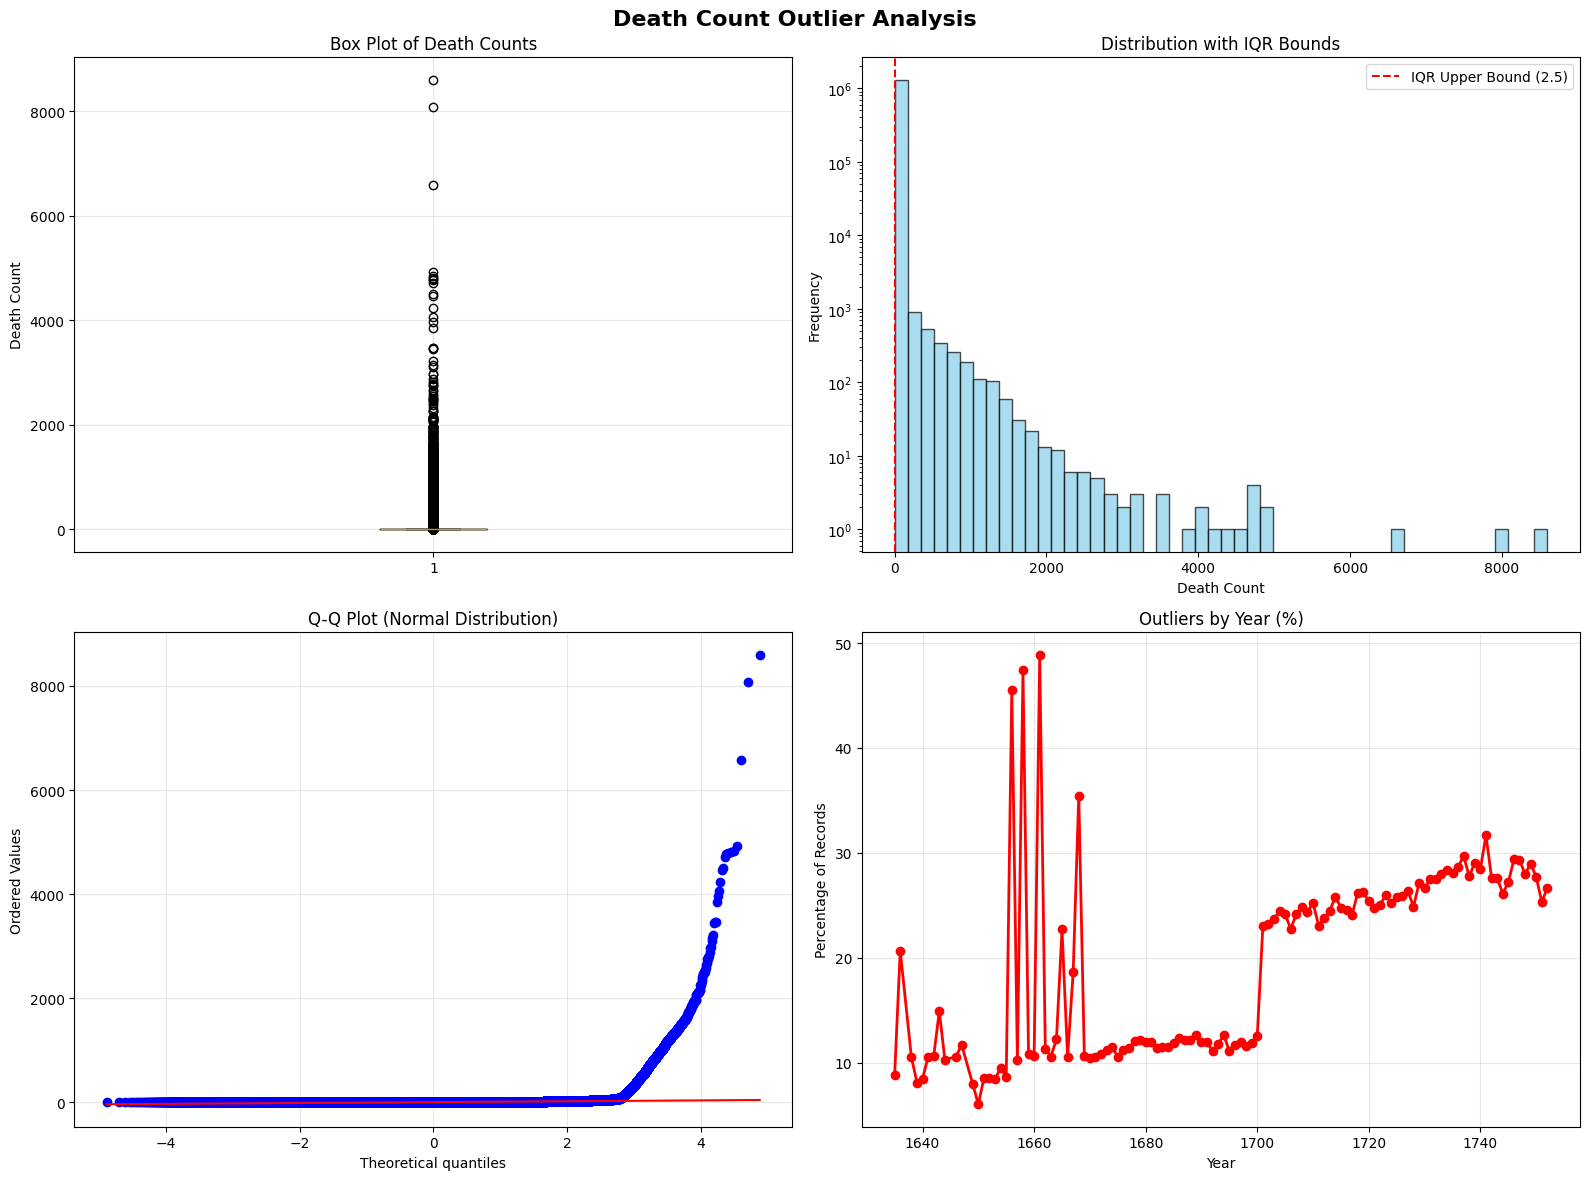


🔍 Outlier Characteristics:

Top 10 Outliers:


KeyError: 'week_id'

In [8]:
print(f"📊 Statistical Outlier Detection:")
print("="*40)

if 'count' in bills.columns:
    # Basic statistics
    count_stats = bills['count'].describe()
    print(f"Death Count Statistics:")
    print(count_stats)
    
    # IQR method for outlier detection
    Q1 = bills['count'].quantile(0.25)
    Q3 = bills['count'].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_iqr = bills[(bills['count'] < lower_bound) | (bills['count'] > upper_bound)]
    
    print(f"\n📈 IQR Outlier Detection:")
    print(f"  IQR bounds: [{lower_bound:.1f}, {upper_bound:.1f}]")
    print(f"  Outliers detected: {len(outliers_iqr):,} records ({len(outliers_iqr)/len(bills)*100:.2f}%)")
    
    # Z-score method
    z_scores = np.abs(stats.zscore(bills['count']))
    outliers_zscore = bills[z_scores > 3]
    
    print(f"\n📊 Z-Score Outlier Detection (|z| > 3):")
    print(f"  Outliers detected: {len(outliers_zscore):,} records ({len(outliers_zscore)/len(bills)*100:.2f}%)")
    
    # Visualize outliers
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Death Count Outlier Analysis', fontsize=16, fontweight='bold')
    
    # Box plot
    axes[0,0].boxplot(bills['count'])
    axes[0,0].set_title('Box Plot of Death Counts')
    axes[0,0].set_ylabel('Death Count')
    axes[0,0].grid(True, alpha=0.3)
    
    # Histogram with outlier boundaries
    axes[0,1].hist(bills['count'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,1].axvline(upper_bound, color='red', linestyle='--', label=f'IQR Upper Bound ({upper_bound:.1f})')
    if lower_bound > 0:
        axes[0,1].axvline(lower_bound, color='red', linestyle='--', label=f'IQR Lower Bound ({lower_bound:.1f})')
    axes[0,1].set_xlabel('Death Count')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Distribution with IQR Bounds')
    axes[0,1].legend()
    axes[0,1].set_yscale('log')
    
    # Q-Q plot
    stats.probplot(bills['count'], dist="norm", plot=axes[1,0])
    axes[1,0].set_title('Q-Q Plot (Normal Distribution)')
    axes[1,0].grid(True, alpha=0.3)
    
    # Time series of outliers
    if 'year' in bills.columns:
        outlier_by_year = outliers_iqr.groupby('year').size()
        all_years = bills.groupby('year').size()
        outlier_pct_by_year = (outlier_by_year / all_years * 100).fillna(0)
        
        axes[1,1].plot(outlier_pct_by_year.index, outlier_pct_by_year.values, 
                       marker='o', linewidth=2, color='red')
        axes[1,1].set_xlabel('Year')
        axes[1,1].set_ylabel('Percentage of Records')
        axes[1,1].set_title('Outliers by Year (%)')
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Analyze outlier characteristics
    if len(outliers_iqr) > 0:
        print(f"\n🔍 Outlier Characteristics:")
        
        # Top outliers
        top_outliers = outliers_iqr.nlargest(10, 'count')
        print(f"\nTop 10 Outliers:")
        for _, outlier in top_outliers.iterrows():
            parish_name = parishes.set_index('id')['parish_name'].get(outlier['parish_id'], f'Parish {outlier["parish_id"]}') if parishes is not None else f'Parish {outlier["parish_id"]}'
            print(f"  {parish_name[:25]:25} {outlier['year']} Week {outlier['week_id']:15} - {outlier['count']:,} {outlier.get('count_type', 'deaths')}")
        
        # Outliers by year
        if 'year' in outliers_iqr.columns:
            outlier_years = outliers_iqr['year'].value_counts().head(5)
            print(f"\nYears with most outliers:")
            for year, count in outlier_years.items():
                print(f"  {year}: {count} outlier records")
        
        # Outliers by parish
        if 'parish_id' in outliers_iqr.columns:
            outlier_parishes = outliers_iqr['parish_id'].value_counts().head(5)
            print(f"\nParishes with most outliers:")
            for parish_id, count in outlier_parishes.items():
                parish_name = parishes.set_index('id')['parish_name'].get(parish_id, f'Parish {parish_id}') if parishes is not None else f'Parish {parish_id}'
                print(f"  {parish_name[:30]:30} - {count} outlier records")

## Historical Plausibility Assessment

In [9]:
print(f"🏛️ Historical Plausibility Assessment:")
print("="*45)

plausibility_issues = []

# 1. Weekly death count plausibility
if 'count' in bills.columns:
    # For historical London parishes, weekly deaths typically:
    # - Small parishes: 0-5 deaths per week normally
    # - Large parishes: 5-20 deaths per week normally  
    # - Crisis periods: could be 5-10x normal
    
    very_high_weekly = bills[bills['count'] > 100]  # More than 100 deaths per week
    extremely_high = bills[bills['count'] > 500]   # More than 500 deaths per week
    
    print(f"Weekly Death Count Plausibility:")
    print(f"  Records with >100 deaths/week: {len(very_high_weekly):,} ({len(very_high_weekly)/len(bills)*100:.2f}%)")
    print(f"  Records with >500 deaths/week: {len(extremely_high):,} ({len(extremely_high)/len(bills)*100:.2f}%)")
    
    if len(extremely_high) > 0:
        print(f"  ⚠️ Extremely high weekly deaths may indicate:")
        print(f"     - Major plague outbreaks")
        print(f"     - Data entry errors")
        print(f"     - Aggregated data (multiple weeks/parishes)")
        plausibility_issues.append(f"Extremely high weekly deaths: {len(extremely_high)} records")

# 2. Temporal continuity assessment
if 'year' in bills.columns:
    year_coverage = bills['year'].value_counts().sort_index()
    year_range = range(bills['year'].min(), bills['year'].max() + 1)
    missing_years = [year for year in year_range if year not in year_coverage.index]
    
    print(f"\nTemporal Coverage:")
    print(f"  Year range: {bills['year'].min()} - {bills['year'].max()} ({bills['year'].max() - bills['year'].min() + 1} years)")
    print(f"  Years with data: {len(year_coverage)}")
    print(f"  Missing years: {len(missing_years)}")
    
    if missing_years:
        print(f"  Missing year examples: {missing_years[:10]}")
        
        # Check for long gaps
        if len(missing_years) > 5:
            plausibility_issues.append(f"Temporal gaps: {len(missing_years)} missing years")
    
    # Check for years with very few records (possible incomplete data)
    sparse_years = year_coverage[year_coverage < year_coverage.quantile(0.1)]
    if len(sparse_years) > 0:
        print(f"  Years with few records (<10th percentile): {len(sparse_years)}")
        print(f"  Examples: {dict(sparse_years.head())}")

# 3. Parish activity patterns
if 'parish_id' in bills.columns:
    parish_activity = bills.groupby('parish_id').agg({
        'year': ['min', 'max', 'nunique'],
        'count': ['sum', 'count']
    }).round(2)
    
    parish_activity.columns = ['_'.join(col).strip() for col in parish_activity.columns]
    parish_activity['years_span'] = parish_activity['year_max'] - parish_activity['year_min'] + 1
    parish_activity['years_active'] = parish_activity['year_nunique']
    parish_activity['activity_rate'] = parish_activity['years_active'] / parish_activity['years_span']
    
    print(f"\nParish Activity Patterns:")
    print(f"  Parishes with data: {len(parish_activity)}")
    print(f"  Average activity rate: {parish_activity['activity_rate'].mean():.2f} (1.0 = continuous)")
    
    # Find parishes with very low activity rates (possible data quality issues)
    low_activity = parish_activity[parish_activity['activity_rate'] < 0.3]  # Active <30% of their span
    if len(low_activity) > 0:
        print(f"  Parishes with low activity (<30% of time span): {len(low_activity)}")
        plausibility_issues.append(f"Low parish activity: {len(low_activity)} parishes")

# 4. Known historical events cross-check
print(f"\nHistorical Context Checks:")

# Major plague years in London
known_plague_years = [1603, 1625, 1636, 1665, 1666]
available_plague_years = [year for year in known_plague_years if year in bills['year'].values]

if available_plague_years:
    print(f"  Known plague years in dataset: {available_plague_years}")
    
    # Check if mortality is elevated in these years
    yearly_mortality = bills.groupby('year')['count'].sum()
    normal_mortality = yearly_mortality.drop(available_plague_years, errors='ignore').median()
    
    for plague_year in available_plague_years:
        if plague_year in yearly_mortality.index:
            plague_mortality = yearly_mortality[plague_year]
            ratio = plague_mortality / normal_mortality if normal_mortality > 0 else 0
            print(f"    {plague_year}: {plague_mortality:,} deaths ({ratio:.1f}x normal)")
            
            if ratio < 2:  # Expect at least 2x mortality in plague years
                plausibility_issues.append(f"Low plague year mortality in {plague_year}: only {ratio:.1f}x normal")
else:
    print(f"  No known plague years (1603, 1625, 1636, 1665-1666) in dataset")

# 5. Seasonal pattern plausibility
if 'week_id' in bills.columns and bills['week_id'].str.contains('-').any():
    # Extract week numbers
    week_parts = bills['week_id'].str.split('-', expand=True)
    if len(week_parts.columns) >= 3:
        bills_temp = bills.copy()
        bills_temp['week_num'] = pd.to_numeric(week_parts.iloc[:, -1], errors='coerce')
        
        # Group by seasons (approximate)
        bills_temp['season'] = bills_temp['week_num'].apply(lambda x: 
            'Winter' if x in [1,2,3,4,5,6,50,51,52] 
            else 'Spring' if x in [7,8,9,10,11,12,13,14,15,16,17,18,19,20] 
            else 'Summer' if x in [21,22,23,24,25,26,27,28,29,30,31,32,33,34] 
            else 'Autumn' if x in [35,36,37,38,39,40,41,42,43,44,45,46,47,48,49] 
            else 'Unknown')
        
        seasonal_mortality = bills_temp.groupby('season')['count'].mean()
        if 'Winter' in seasonal_mortality.index and 'Summer' in seasonal_mortality.index:
            winter_summer_ratio = seasonal_mortality['Winter'] / seasonal_mortality['Summer']
            print(f"\nSeasonal Mortality Pattern:")
            print(f"  Winter/Summer mortality ratio: {winter_summer_ratio:.2f}")
            
            # Historically, winter mortality was typically higher
            if winter_summer_ratio < 0.8:
                print(f"  ⚠️ Unusually low winter mortality (expected higher than summer)")
                plausibility_issues.append(f"Unusual seasonal pattern: winter {winter_summer_ratio:.2f}x summer")
            else:
                print(f"  ✅ Plausible seasonal pattern")

# Summary of plausibility issues
print(f"\n📋 Historical Plausibility Issues:")
if plausibility_issues:
    for i, issue in enumerate(plausibility_issues, 1):
        print(f"  {i}. {issue}")
else:
    print(f"  ✅ No major historical plausibility issues detected")

🏛️ Historical Plausibility Assessment:
Weekly Death Count Plausibility:
  Records with >100 deaths/week: 3,149 (0.24%)
  Records with >500 deaths/week: 1,222 (0.09%)
  ⚠️ Extremely high weekly deaths may indicate:
     - Major plague outbreaks
     - Data entry errors
     - Aggregated data (multiple weeks/parishes)

Temporal Coverage:
  Year range: 1635 - 1752 (118 years)
  Years with data: 115
  Missing years: 3
  Missing year examples: [1637, 1645, 1648]
  Years with few records (<10th percentile): 12
  Examples: {1635: np.int64(248), 1636: np.int64(4960), 1640: np.int64(496), 1641: np.int64(4712), 1643: np.int64(248)}

Parish Activity Patterns:
  Parishes with data: 153
  Average activity rate: 0.98 (1.0 = continuous)

Historical Context Checks:
  Known plague years in dataset: [1636, 1665, 1666]
    1636: 19,210 deaths (0.5x normal)
    1665: 149,413 deaths (3.7x normal)
    1666: 31,029 deaths (0.8x normal)

📋 Historical Plausibility Issues:
  1. Extremely high weekly deaths: 122

## Data Completeness Analysis

📊 Data Completeness Analysis:
Overall Data Completeness: 100.0%
Missing cells: 0 out of 13,053,000


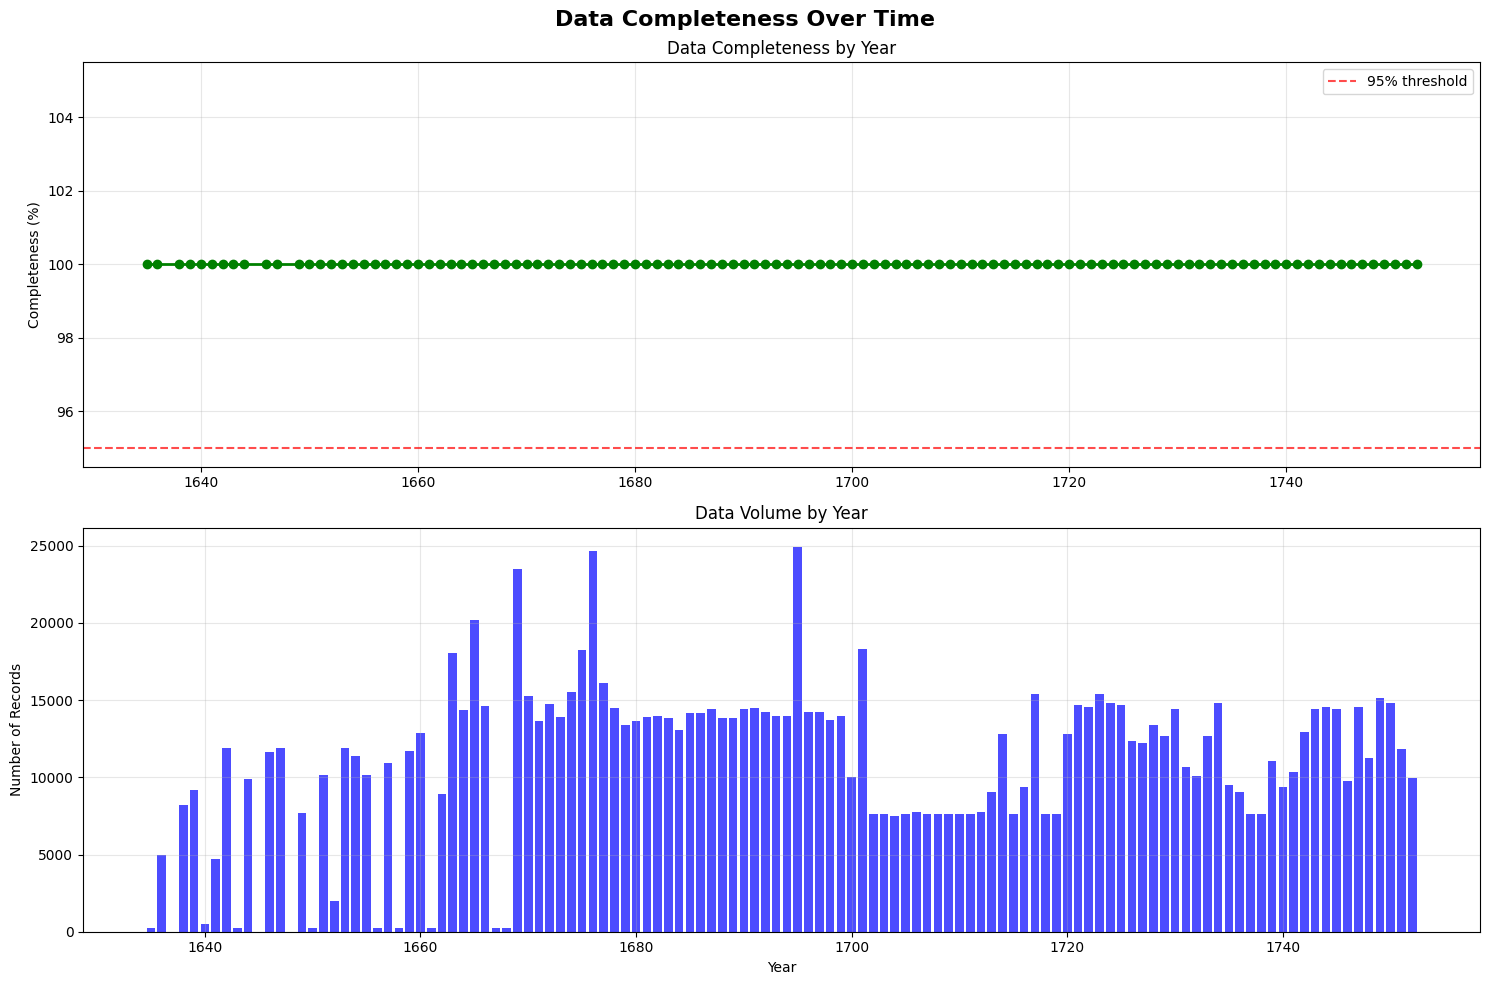


Completeness Summary:
  Average parish completeness: 100.0%
  Parishes with 100% completeness: 153
  Parishes with <90% completeness: 0

🚩 Quality Flags in Data:
  Records flagged as 'missing': 851,140 (65.2%)
  Records flagged as 'illegible': 0 (0.0%)
  Total quality-flagged records: 851,140 (65.2%)


In [10]:
print(f"📊 Data Completeness Analysis:")
print("="*40)

# Overall completeness score
total_possible_cells = len(bills) * len(bills.columns)
total_missing_cells = bills.isnull().sum().sum()
completeness_score = (1 - total_missing_cells / total_possible_cells) * 100

print(f"Overall Data Completeness: {completeness_score:.1f}%")
print(f"Missing cells: {total_missing_cells:,} out of {total_possible_cells:,}")

# Completeness by year
if 'year' in bills.columns:
    yearly_completeness = []
    for year in sorted(bills['year'].unique()):
        year_data = bills[bills['year'] == year]
        year_missing = year_data.isnull().sum().sum()
        year_total = len(year_data) * len(year_data.columns)
        year_completeness = (1 - year_missing / year_total) * 100 if year_total > 0 else 0
        yearly_completeness.append({
            'year': year,
            'records': len(year_data),
            'completeness': year_completeness,
            'missing_cells': year_missing
        })
    
    completeness_df = pd.DataFrame(yearly_completeness)
    
    # Find years with low completeness
    low_completeness_years = completeness_df[completeness_df['completeness'] < 95]
    if len(low_completeness_years) > 0:
        print(f"\nYears with <95% completeness:")
        for _, year_info in low_completeness_years.iterrows():
            print(f"  {year_info['year']}: {year_info['completeness']:.1f}% complete ({year_info['records']} records)")
    
    # Visualize completeness over time
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    fig.suptitle('Data Completeness Over Time', fontsize=16, fontweight='bold')
    
    # Completeness percentage
    axes[0].plot(completeness_df['year'], completeness_df['completeness'], 
                 marker='o', linewidth=2, color='green')
    axes[0].set_ylabel('Completeness (%)')
    axes[0].set_title('Data Completeness by Year')
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=95, color='red', linestyle='--', alpha=0.7, label='95% threshold')
    axes[0].legend()
    
    # Number of records
    axes[1].bar(completeness_df['year'], completeness_df['records'], 
                alpha=0.7, color='blue')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Number of Records')
    axes[1].set_title('Data Volume by Year')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Completeness by parish
if 'parish_id' in bills.columns:
    parish_completeness = []
    for parish_id in bills['parish_id'].unique():
        parish_data = bills[bills['parish_id'] == parish_id]
        parish_missing = parish_data.isnull().sum().sum()
        parish_total = len(parish_data) * len(parish_data.columns)
        parish_comp = (1 - parish_missing / parish_total) * 100 if parish_total > 0 else 0
        
        parish_name = parishes.set_index('id')['parish_name'].get(parish_id, f'Parish {parish_id}') if parishes is not None else f'Parish {parish_id}'
        
        parish_completeness.append({
            'parish_id': parish_id,
            'parish_name': parish_name,
            'records': len(parish_data),
            'completeness': parish_comp
        })
    
    parish_comp_df = pd.DataFrame(parish_completeness)
    
    # Parishes with low completeness
    low_comp_parishes = parish_comp_df[parish_comp_df['completeness'] < 95].sort_values('completeness')
    if len(low_comp_parishes) > 0:
        print(f"\nParishes with <95% completeness:")
        for _, parish_info in low_comp_parishes.head(10).iterrows():
            print(f"  {parish_info['parish_name'][:30]:30} - {parish_info['completeness']:.1f}% ({parish_info['records']} records)")
    
    print(f"\nCompleteness Summary:")
    print(f"  Average parish completeness: {parish_comp_df['completeness'].mean():.1f}%")
    print(f"  Parishes with 100% completeness: {(parish_comp_df['completeness'] == 100).sum()}")
    print(f"  Parishes with <90% completeness: {(parish_comp_df['completeness'] < 90).sum()}")

# Flag columns for specific quality issues
if 'missing' in bills.columns or 'illegible' in bills.columns:
    print(f"\n🚩 Quality Flags in Data:")
    
    if 'missing' in bills.columns:
        missing_flagged = bills['missing'].sum()
        print(f"  Records flagged as 'missing': {missing_flagged:,} ({missing_flagged/len(bills)*100:.1f}%)")
    
    if 'illegible' in bills.columns:
        illegible_flagged = bills['illegible'].sum()
        print(f"  Records flagged as 'illegible': {illegible_flagged:,} ({illegible_flagged/len(bills)*100:.1f}%)")
    
    # Combined quality issues
    if 'missing' in bills.columns and 'illegible' in bills.columns:
        quality_issues_total = bills['missing'].sum() + bills['illegible'].sum()
        print(f"  Total quality-flagged records: {quality_issues_total:,} ({quality_issues_total/len(bills)*100:.1f}%)")

## Recommendations for Data Cleaning

In [11]:
print(f"🛠️ Data Quality Recommendations:")
print("="*40)

recommendations = []

# Based on the analysis above, generate specific recommendations

# 1. Missing data recommendations
if missing_df['null_count'].sum() > 0:
    high_missing_cols = missing_df[missing_df['null_percentage'] > 5]
    if len(high_missing_cols) > 0:
        recommendations.append({
            'priority': 'HIGH',
            'category': 'Missing Data',
            'issue': f"{len(high_missing_cols)} columns with >5% missing data",
            'recommendation': 'Investigate patterns, consider imputation or exclusion criteria'
        })

# 2. Consistency issues
if consistency_issues:
    recommendations.append({
        'priority': 'HIGH',
        'category': 'Data Consistency',
        'issue': f"{len(consistency_issues)} consistency issues detected",
        'recommendation': 'Review and correct data entry errors, validate against source documents'
    })

# 3. Outlier recommendations
if 'count' in bills.columns:
    outlier_count = len(bills[(bills['count'] > bills['count'].quantile(0.99) * 3)])
    if outlier_count > 0:
        recommendations.append({
            'priority': 'MEDIUM',
            'category': 'Statistical Outliers',
            'issue': f"{outlier_count} extreme outliers in death counts",
            'recommendation': 'Verify against historical records, check for transcription errors'
        })

# 4. Historical plausibility
if plausibility_issues:
    recommendations.append({
        'priority': 'MEDIUM',
        'category': 'Historical Plausibility',
        'issue': f"{len(plausibility_issues)} plausibility concerns",
        'recommendation': 'Cross-reference with historical sources and demographic data'
    })

# 5. Completeness recommendations
if completeness_score < 95:
    recommendations.append({
        'priority': 'MEDIUM',
        'category': 'Data Completeness',
        'issue': f"Overall completeness {completeness_score:.1f}% (<95%)",
        'recommendation': 'Assess impact of missing data on analysis, consider additional data sources'
    })

# 6. Duplicate data
key_columns = ['parish_id', 'year', 'week_id', 'count_type']
if all(col in bills.columns for col in key_columns):
    duplicate_count = bills.duplicated(subset=key_columns).sum()
    if duplicate_count > 0:
        recommendations.append({
            'priority': 'HIGH',
            'category': 'Duplicate Records',
            'issue': f"{duplicate_count} potential duplicate records",
            'recommendation': 'Remove or consolidate duplicates after verification'
        })

# 7. Format standardization
recommendations.append({
    'priority': 'LOW',
    'category': 'Standardization',
    'issue': 'Data format consistency',
    'recommendation': 'Standardize date formats, parish names, and categorical variables'
})

# Display recommendations
if recommendations:
    priority_order = {'HIGH': 1, 'MEDIUM': 2, 'LOW': 3}
    recommendations.sort(key=lambda x: priority_order[x['priority']])
    
    for i, rec in enumerate(recommendations, 1):
        priority_emoji = {'HIGH': '🔴', 'MEDIUM': '🟡', 'LOW': '🟢'}[rec['priority']]
        print(f"\n{i}. {priority_emoji} {rec['priority']} - {rec['category']}")
        print(f"   Issue: {rec['issue']}")
        print(f"   Recommendation: {rec['recommendation']}")
else:
    print("✅ No major data quality issues requiring immediate attention")

# Summary quality score
quality_factors = {
    'completeness': min(completeness_score / 100, 1.0),
    'consistency': 1.0 - min(len(consistency_issues) / 10, 1.0),  # Penalize up to 10 issues
    'plausibility': 1.0 - min(len(plausibility_issues) / 10, 1.0),
    'outliers': 1.0 - min((outlier_count if 'outlier_count' in locals() else 0) / len(bills), 0.1)  # Cap penalty at 10%
}

overall_quality_score = np.mean(list(quality_factors.values())) * 100

print(f"\n📊 Overall Data Quality Score: {overall_quality_score:.1f}/100")
print(f"\nQuality Factor Breakdown:")
for factor, score in quality_factors.items():
    print(f"  {factor.title():15} - {score*100:5.1f}%")

print(f"\n📋 Data Quality Summary:")
if overall_quality_score >= 90:
    print(f"  ✅ Excellent data quality - minimal issues detected")
elif overall_quality_score >= 75:
    print(f"  ✓ Good data quality - some issues to address")
elif overall_quality_score >= 60:
    print(f"  ⚠️ Fair data quality - several issues need attention")
else:
    print(f"  🔴 Poor data quality - significant issues require immediate attention")

print(f"\n💡 Next Steps:")
print(f"  1. Address HIGH priority recommendations first")
print(f"  2. Create data cleaning pipeline with validation rules")
print(f"  3. Document all data transformations and exclusions")
print(f"  4. Establish ongoing data quality monitoring")
print(f"  5. Cross-validate against external historical sources")

🛠️ Data Quality Recommendations:

1. 🔴 HIGH - Data Consistency
   Issue: 1 consistency issues detected
   Recommendation: Review and correct data entry errors, validate against source documents

2. 🟡 MEDIUM - Statistical Outliers
   Issue: 3126 extreme outliers in death counts
   Recommendation: Verify against historical records, check for transcription errors

3. 🟡 MEDIUM - Historical Plausibility
   Issue: 3 plausibility concerns
   Recommendation: Cross-reference with historical sources and demographic data

4. 🟢 LOW - Standardization
   Issue: Data format consistency
   Recommendation: Standardize date formats, parish names, and categorical variables

📊 Overall Data Quality Score: 89.9/100

Quality Factor Breakdown:
  Completeness    - 100.0%
  Consistency     -  90.0%
  Plausibility    -  70.0%
  Outliers        -  99.8%

📋 Data Quality Summary:
  ✓ Good data quality - some issues to address

💡 Next Steps:
  1. Address HIGH priority recommendations first
  2. Create data cleaning 

# Create timeline showing availability of weekly vs general bills
def create_coverage_timeline():
    """Create timeline showing availability of weekly vs general bills."""
    
    # Count records by year and bill type
    yearly_counts = bills.groupby(['year', 'bill_type']).size().unstack(fill_value=0)
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), sharex=True)
    fig.suptitle('Bills of Mortality: Data Availability Over Time', fontsize=16, fontweight='bold')
    
    # Plot record counts (log scale for better visibility)
    if 'weekly' in yearly_counts.columns:
        ax1.bar(yearly_counts.index, yearly_counts['weekly'], 
               alpha=0.7, label='Weekly Bills', color='skyblue', width=0.8)
    if 'general' in yearly_counts.columns:
        ax1.bar(yearly_counts.index, yearly_counts['general'], 
               alpha=0.7, label='General Bills', color='orange', 
               bottom=yearly_counts.get('weekly', 0), width=0.8)
    
    ax1.set_ylabel('Number of Records (log scale)')
    ax1.set_title('Record Counts by Year and Bill Type', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # Plot presence/absence
    presence_data = (yearly_counts > 0).astype(int)
    bottom_vals = np.zeros(len(yearly_counts))
    
    if 'weekly' in presence_data.columns:
        ax2.bar(presence_data.index, presence_data['weekly'], 
               alpha=0.7, label='Weekly Bills Available', color='skyblue', width=0.8)
        bottom_vals = presence_data['weekly']
    
    if 'general' in presence_data.columns:
        ax2.bar(presence_data.index, presence_data['general'], 
               alpha=0.7, label='General Bills Available', color='orange', 
               bottom=bottom_vals, width=0.8)
    
    # Highlight major gap period
    ax2.axvspan(1680, 1699, alpha=0.3, color='red', label='General Bills Gap')
    
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Data Type Available')
    ax2.set_title('Data Availability by Bill Type', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_yticks([0, 1, 2])
    ax2.set_yticklabels(['None', 'One Type', 'Both Types'])
    
    # Add annotation for major gap
    ax2.annotate('General Bills\\nMissing 1680-1699', 
                xy=(1690, 0.5), xytext=(1710, 1.5),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                fontsize=10, ha='center', color='red')
    
    plt.tight_layout()
    plt.show()

# Ensure we have the gap analysis data - rerun if needed
if 'bill_gaps' not in locals() or 'coverage_df' not in locals():
    print("Rerunning gap analysis...")
    bill_gaps = analyze_coverage_gaps()
    coverage_df = analyze_parish_coverage()

# Generate the visualization
print("📊 Creating data coverage timeline...")
create_coverage_timeline()

print("\\n✅ Coverage analysis complete!")
print(f"\\nSummary of findings:")

# Safely check for gaps
general_gap_1680_1699 = [y for y in bill_gaps.get('general', []) if 1680 <= y <= 1699] if 'bill_gaps' in locals() else []
total_weekly_gaps = len(bill_gaps.get('weekly', [])) if 'bill_gaps' in locals() else 0
avg_coverage = coverage_df['coverage_rate'].mean() if 'coverage_df' in locals() else 0

print(f"- General Bills missing for 1680-1699 ({len(general_gap_1680_1699)} years)")  
print(f"- Weekly Bills missing for scattered early years ({total_weekly_gaps} years total)")
print(f"- Overall parish coverage rate: {avg_coverage:.1%}")

# Export coverage data for further analysis if needed
coverage_summary = {
    'general_gaps': bill_gaps.get('general', []) if 'bill_gaps' in locals() else [],
    'weekly_gaps': bill_gaps.get('weekly', []) if 'bill_gaps' in locals() else [], 
    'parish_coverage_rate': avg_coverage,
    'parishes_with_gaps': len(coverage_df[coverage_df['years_missing'] > 0]) if 'coverage_df' in locals() else 0
}

print(f"\\n📋 Coverage summary stored in 'coverage_summary' variable for further analysis.")

## Data Coverage Analysis by Parish and Year

This section analyzes which years of data are available for each parish and identifies gaps in our data coverage, particularly focusing on the missing General Bills in later years and missing Weekly Bills in earlier years.